In [5]:
train_df.head()

NameError: name 'train_df' is not defined

In [4]:
y_train = train_df.pop("target").values
y_test = test_df.pop("target").values

NameError: name 'train_df' is not defined

In [26]:
X_train = train_df.values
X_test = test_df.values

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

0.990228013029316
[[343   4]
 [  2 265]]


In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing']))

              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99       347
    Phishing       0.99      0.99      0.99       267

    accuracy                           0.99       614
   macro avg       0.99      0.99      0.99       614
weighted avg       0.99      0.99      0.99       614



In [29]:
X_test_df = test_df.copy() 
misclassified_indices = (y_test != y_test_pred)
misclassified_samples = X_test_df[misclassified_indices] 
actual_labels_misclassified = y_test[misclassified_indices]
predicted_labels_misclassified = y_test_pred[misclassified_indices]

print("Misclassified samples:")
for i in range(len(misclassified_samples)):
    print(f"Sample features: {misclassified_samples.iloc[i].values}")
    print(f"Actual: {actual_labels_misclassified[i]}, Predicted: {predicted_labels_misclassified[i]}")
    print("-" * 20)

Misclassified samples:
Sample features: [ 0 -1  0  0  0 -1 -1  1  0  0  0  0  1  0 -1 -1  0  0  0  0  0  0  0 -1
  0  1 -1  0  0  0]
Actual: -1, Predicted: 1
--------------------
Sample features: [ 1  1  1  0  1 -1  1  1 -1  0  0  1  1  0 -1  1  0  1  1  0  0  0  0  1
  0  0 -1  0  1  0]
Actual: -1, Predicted: 1
--------------------
Sample features: [ 0 -1  0  0  0 -1  0 -1  1  0  0  0 -1  0 -1 -1  0  0  0  0  0  0  0  0
  1  1 -1  0  1  0]
Actual: 1, Predicted: -1
--------------------
Sample features: [ 0 -1  0  0  0 -1  0 -1  1  0  0  0 -1  0 -1 -1  0  0  0  0  0  0  0  0
  1  1 -1  0  1  0]
Actual: 1, Predicted: -1
--------------------
Sample features: [ 0 -1  0  0  0 -1  1  1 -1  0  0  0  1  0  0 -1  0  0  0  0  0  0  0 -1
  1  0 -1  0  0  0]
Actual: -1, Predicted: 1
--------------------
Sample features: [ 1  1  1  0  1 -1  1  1 -1  0  0  1  1  0 -1  1  0  1  1  0  0  0  0  1
  1  0 -1  0  1  0]
Actual: -1, Predicted: 1
--------------------


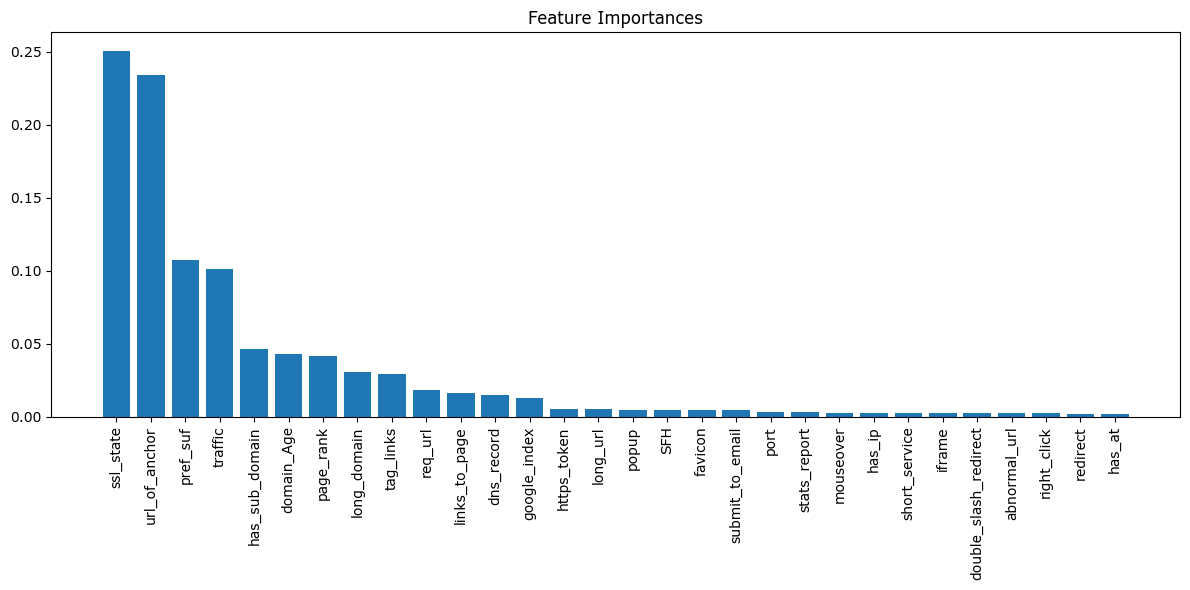

In [30]:
import matplotlib.pyplot as plt
import numpy as np

importances = clf.feature_importances_
feature_names = train_df.columns

sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [31]:
from sklearn.model_selection import cross_val_score

# Використовуйте ВЕСЬ набір даних X (X_train + X_test) та y (y_train + y_test) для більш надійної крос-валідації
# або просто на тренувальному:
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy') # cv=5 означає 5-fold CV
print(f"Cross-validation accuracies: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")
print(f"Std CV accuracy: {cv_scores.std()}")

Cross-validation accuracies: [0.97560976 0.95392954 0.9701087  0.95652174 0.96467391]
Mean CV accuracy: 0.9641687286438081
Std CV accuracy: 0.00812099717603708


In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Увага: GridSearchCV може бути тривалим
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, 
                           scoring='accuracy', verbose=1, n_jobs=-1) # n_jobs=-1 використовує всі ядра
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_clf = grid_search.best_estimator_

# Оцінка найкращої моделі
y_test_pred_best = best_clf.predict(X_test)
print("Accuracy with best estimator:", accuracy_score(y_test, y_test_pred_best))
print(confusion_matrix(y_test, y_test_pred_best))
print(classification_report(y_test, y_test_pred_best, target_names=['Legitimate', 'Phishing']))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy with best estimator: 0.990228013029316
[[343   4]
 [  2 265]]
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99       347
    Phishing       0.99      0.99      0.99       267

    accuracy                           0.99       614
   macro avg       0.99      0.99      0.99       614
weighted avg       0.99      0.99      0.99       614



In [33]:
import joblib
joblib.dump(clf, 'phishing_url_detector_rf.pkl') # або best_clf, якщо робили GridSearchCV

# Потім можна завантажити:
# loaded_model = joblib.load('phishing_url_detector_rf.pkl')
# result = loaded_model.predict(some_new_data)

['phishing_url_detector_rf.pkl']

In [34]:
import os
print(os.getcwd())

C:\Users\Gitpc\OneDrive\Desktop\project\Px\Phishing URL Detection


In [ ]:
import joblib
import pandas as pd
import numpy as np
import os # Додаємо os для роботи зі шляхами

# --- ВАЖЛИВО: Налаштуй ці змінні ---
# Варіант 1: Модель в тій же папці, що і ноутбук
MODEL_FILENAME = 'phishing_url_detector_rf.pkl' # Або 'phishing_url_detector_rf.pkl'
MODEL_PATH = MODEL_FILENAME # Якщо файл в тій же папці

# Варіант 2: Модель в підпапці 'models' (відносно ноутбука)
# MODEL_SUBFOLDER = 'models'
# MODEL_FILENAME = 'phishing_url_detector_rf_best.pkl'
# MODEL_PATH = os.path.join(MODEL_SUBFOLDER, MODEL_FILENAME)

# Варіант 3: Абсолютний шлях до моделі (якщо вона зовсім в іншому місці)
# Заміни на свій реальний шлях!
# Наприклад, для Windows: MODEL_PATH = r"C:\Users\YourUser\Documents\AI_Cybersecurity_Project\models\phishing_url_detector_rf_best.pkl"
# Наприклад, для Linux/macOS: MODEL_PATH = "/home/youruser/projects/ai_cybersecurity/models/phishing_url_detector_rf_best.pkl"
# Якщо використовуєш цей варіант, закоментуй Варіант 1 або 2 вище.
# MODEL_PATH = "ВСТАВ_СЮДИ_ПОВНИЙ_ШЛЯХ_ДО_ФАЙЛУ_МОДЕЛІ" # РОЗКОМЕНТУЙ І ЗАМІНИ

# Перевіримо, чи існує файл за вказаним шляхом
if not os.path.exists(MODEL_PATH):
    print(f"ПОПЕРЕДЖЕННЯ: Файл моделі за шляхом '{MODEL_PATH}' не знайдено.")
    print("Будь ласка, перевір змінні MODEL_FILENAME, MODEL_SUBFOLDER або MODEL_PATH у коді.")
    # Спробуємо знайти в поточній директорії, якщо шлях був складнішим
    if os.path.exists(MODEL_FILENAME):
        print(f"Знайдено файл '{MODEL_FILENAME}' в поточній директорії. Спроба завантажити його.")
        MODEL_PATH = MODEL_FILENAME
    else:
        print(f"Файл '{MODEL_FILENAME}' також не знайдено в поточній директорії.")


# Завантажуємо навчену модель
try:
    # Переконуємося, що MODEL_PATH дійсно вказує на існуючий файл перед спробою завантаження
    if os.path.exists(MODEL_PATH):
        loaded_model = joblib.load(MODEL_PATH)
        print(f"Модель успішно завантажена з '{MODEL_PATH}'.")
    else:
        # Цей блок, ймовірно, не виконається, якщо попередня перевірка спрацювала,
        # але залишаємо для повноти
        print(f"Помилка: Файл моделі за шляхом '{MODEL_PATH}' все ще не знайдено.")
        loaded_model = None
except FileNotFoundError: # Ця помилка все ще може виникнути, якщо шлях динамічно змінився
    print(f"Помилка FileNotFoundError: Файл моделі за шляхом '{MODEL_PATH}' не знайдено.")
    loaded_model = None
except Exception as e:
    print(f"Сталася помилка при завантаженні моделі: {e}")
    loaded_model = None


# Назви ознак (це залишається без змін, якщо структура даних та ж сама)
FEATURE_NAMES = [
    'has_ip', 'long_url', 'short_service', 'has_at', 'double_slash_redirect',
    'pref_suf', 'has_sub_domain', 'ssl_state', 'long_domain', 'favicon',
    'port', 'https_token', 'req_url', 'url_of_anchor', 'tag_links', 'SFH',
    'submit_to_email', 'abnormal_url', 'redirect', 'mouseover',
    'right_click', 'popup', 'iframe', 'domain_Age', 'dns_record',
    'traffic', 'page_rank', 'google_index', 'links_to_page', 'stats_report'
]

# --- Функції для витягнення ознак (extract_features_from_url) ---
# ... (Тут твій код для extract_features_from_url, як у попередньому прикладі) ...
# Я його скорочу тут для стислості, але він має бути повністю реалізований.
def extract_features_from_url(url):
    # Дуже важлива реалізація всіх 30 ознак!
    # Заміни цей блок на свою повну реалізацію
    print("УВАГА: extract_features_from_url не реалізована повністю! Використовуються заглушки.")
    # Приклад-заглушка, яка повертає масив нулів потрібного розміру
    # ТРЕБА ЗАМІНИТИ НА РЕАЛЬНУ ЛОГІКУ!
    return np.zeros((1, len(FEATURE_NAMES)))


# Функція для перевірки одного URL (check_url)
# ... (Тут твій код для check_url, як у попередньому прикладі) ...
def check_url(url_to_check):
    if not loaded_model:
        print("Модель не завантажена. Перевірка неможлива.")
        return None, None

    print(f"\nПеревірка URL: {url_to_check}")
    try:
        url_features = extract_features_from_url(url_to_check)
        if url_features.shape[1] != len(FEATURE_NAMES):
             raise ValueError(f"Неправильна кількість ознак: очікувалося {len(FEATURE_NAMES)}, отримано {url_features.shape[1]}")

        prediction = loaded_model.predict(url_features)
        prediction_proba = loaded_model.predict_proba(url_features)

        if prediction[0] == 1:
            result_label = "Фішинг (Phishing)"
        elif prediction[0] == -1:
            result_label = "Легітимний (Legitimate)"
        else:
            result_label = f"Невідомий прогноз: {prediction[0]}"

        print(f"Прогноз: {result_label}")
        print(f"Ймовірності класів (Legitimate (-1), Phishing (1)): {prediction_proba[0]}")
        return result_label, prediction_proba[0]

    except ValueError as ve:
        print(f"Помилка під час витягнення ознак або прогнозування: {ve}")
        return "Помилка обробки", None
    except Exception as e:
        print(f"Загальна помилка під час перевірки URL: {e}")
        return "Помилка обробки", None


# Код для інтерактивного введення в Jupyter (якщо використовуєш)
# import ipywidgets as widgets # Якщо використовуєш віджети
# from IPython.display import display, clear_output # Якщо використовуєш віджети

# ... (Код віджетів та їх обробника, якщо він потрібен) ...

# Простий варіант з input() для тестування
if __name__ == '__main__':
    if loaded_model:
        url_input = input("Введіть URL для перевірки: ")
        if url_input:
            predicted_label, probabilities = check_url(url_input.strip())
        else:
            print("URL не введено.")
    else:
        print("Модель не була завантажена коректно. Перевірка неможлива.")